<h1 align="center"><font color='White'>Fusion Reaction Cross Section</font></h1>

In a nuclear fusion reaction two atomic nuclei combine to form a single nucleus of lower total mass, the difference in mass, $\Delta m$ being released as energy in accordance with $E=\Delta mc^2$. It is this process which powers stars (in our own sun, hydrogen nuclei are fused into helium), and nuclear fusion has been actively pursued as a potential clean and cheap energy source in reactors on Earth for over 50 years.

In deciding which nuclei should be the "fuel" in a nuclear fusion reactor, an important quantity is the "cross section", σ, a measure of the reaction probability as a function of the kinetic energy of the reactant nuclei. The nuclei are positively-charged and so repel each other (Coulomb repulsion): fusion is only possible if they are able to overcome this repulsion to approach each other at close range. This, in turn, demands that they have a large relative speed and hence kinetic energy. For a viable fusion reactor on Earth, this corresponds to a temperature of many millions of Kelvin.

The IAEA's Nuclear Data Section provides a database of evaluated nuclear data, ENDF, that can be used to illustrate the fusion cross section. The code below uses data from ENDF to plot the fusion cross section for three fusion reactions:

\begin{align*}
D + T &\rightarrow \alpha (3.5 \, \text{MeV}) + n (14.1 \, \text{MeV}) \\
D + D &\rightarrow T (1.01 \, \text{MeV}) + p (3.02 \, \text{MeV}) & [50\% \, \text{probability}] \\
&\rightarrow ^3He (0.82 \, \text{MeV}) + n (2.45 \, \text{MeV}) & [50\% \, \text{probability}] \\
^3He + ^3He &\rightarrow 2p + \alpha + 12.86 \, \text{MeV} \\
T + ^3He &\rightarrow n + p + \alpha + 12.1 \, \text{MeV} & [59\% \, \text{probability}] \\
&\rightarrow D (9.52 \, \text{MeV}) + \alpha (4.8 \, \text{MeV}) & [41\% \, \text{probability}] \\
T + T &\rightarrow 2n + \alpha + 11.3 \, \text{MeV} \\
p + ^{11}B &\rightarrow 3\alpha + 8.7 \, \text{MeV}
\end{align*}


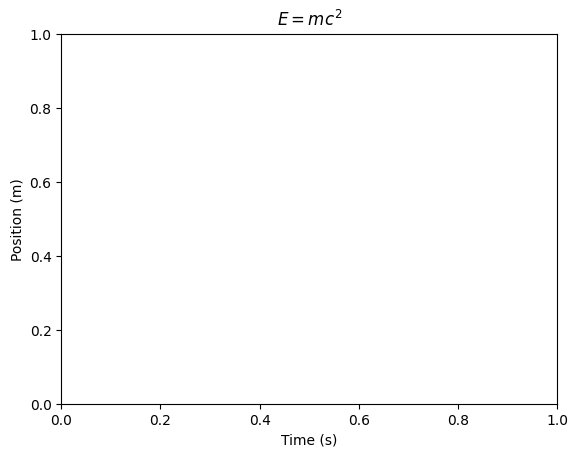

In [2]:
import matplotlib.pyplot as plt

# Enable LaTeX and configure the LaTeX preamble to include additional packages
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

plt.figure()
plt.title(r'$E=mc^2$')  # Example of LaTeX in the title
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


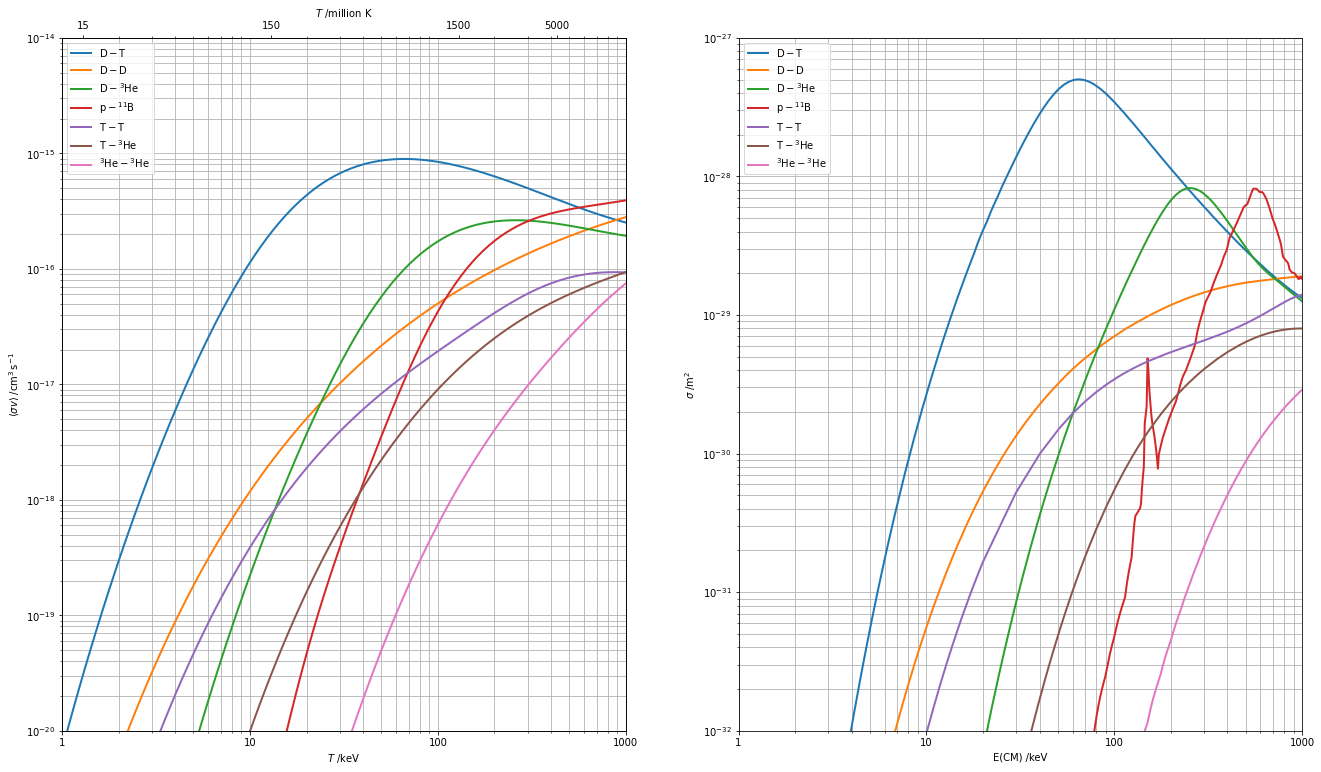

In [2]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from scipy.constants import e, k as kB
from scipy.integrate import quad
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
# rc('text', usetex=True)

# To plot using centre-of-mass energies instead of lab-fixed energies, set True
COFM = True

# Reactant masses in atomic mass units (u).
u = 1.66053906660e-27
masses = {'D': 2.014, 'T': 3.016, '3He': 3.016, '11B': 11.009305167,
          'p': 1.007276466620409}

# Energy grid, 1 – 100,000 keV, evenly spaced in log-space.
Egrid = np.logspace(0, 5, 1000)

class Xsec:
    def __init__(self, m1, m2, xs):
        self.m1, self.m2, self.xs = m1, m2, xs
        self.mr = self.m1 * self.m2 / (self.m1 + self.m2)

    @classmethod
    def read_xsec(cls, filename, CM=True):
        """
        Read in cross section from filename and interpolate to energy grid.
        """
        # Read in the cross section (in barn) as a function of energy (MeV).
        E, xs = np.genfromtxt(filename, comments='#', skip_footer=2, unpack=True)

        if CM:
            # Extract collider and target from filename, accounting for directory prefix
            base_filename = filename.split('/')[-1]  # This isolates the filename from the directory
            collider, target = base_filename.split('_')[:2]
            m1, m2 = masses[target], masses[collider]
            E *= m1 / (m1 + m2)

        # Interpolate the cross section onto the Egrid (keV) and
        # convert from barn to cm2.
        xs = np.interp(Egrid, E*1.e3, xs*1.e-28)
        return cls(m1, m2, xs)

    def __add__(self, other):
        return Xsec(self.m1, self.m2, self.xs + other.xs)

    def __mul__(self, n):
        return Xsec(self.m1, self.m2, n * self.xs)
    __rmul__ = __mul__

    def __getitem__(self, i):
        return self.xs[i]

    def __len__(self):
        return len(self.xs)

xs_names = {
    'D-T': 'Data/D_T_-_a_n.txt',              # D + T -> α + n
    'D-D_a': 'Data/D_D_-_T_p.txt',            # D + D -> T + p
    'D-D_b': 'Data/D_D_-_3He_n.txt',          # D + D -> 3He + n
    'D-3He': 'Data/D_3He_-_4He_p-endf.txt',   # D + 3He -> α + p
    'p-B': 'Data/p_11B_-_3a.txt',             # p + 11B -> 3α
    'T-T': 'Data/T_T_-_4He_n_n.txt',          # T + T -> 4He + 2n
    'T-3He_a': 'Data/T_3He_-_n_p_4He.txt',    # T + 3He -> 4He + n + p
    'T-3He_b': 'Data/T_3He_-_D_4He.txt',      # T + 3He -> 4He + D
    '3He-3He': 'Data/3He_3He_-_p_p_4He.txt',  # 3He + 3He -> 4He + 2p
}

xs = {}
for xs_id, xs_name in xs_names.items():
    xs[xs_id] = Xsec.read_xsec(xs_name)
# Total D + D fusion cross section is due to equal contributions from the
# above two processes.
xs['D-D'] = xs['D-D_a'] + xs['D-D_b']
xs['T-3He'] = xs['T-3He_a'] + xs['T-3He_b']

def get_reactivity(xs, T):
    """Return reactivity, <sigma.v> in cm3.s-1 for temperature T in keV."""
    T = T[:, None]
    fac = 4 / np.sqrt(2 * np.pi * xs.mr * u)
    fac /= (1000 * T * e)**1.5
    fac *= (1000 * e)**2 
    func = fac * xs.xs * Egrid * np.exp(-Egrid / T)
    I = np.trapz(func, Egrid, axis=1)
    # Convert from m3.s-1 to cm3.s-1
    return I * 1.e6

T = np.logspace(0, 3, 100)

xs_labels = {
    'D-T': '$\mathrm{D-T}$',
    'D-D': '$\mathrm{D-D}$',
    'D-3He': '$\mathrm{D-^3He}$',
    'p-B': '$\mathrm{p-^{11}B}$',
    'T-T': '$\mathrm{T-T}$',
    'T-3He': '$\mathrm{T-^3He}$',
    '3He-3He': '$\mathrm{^3He-^3He}$',
}

# Constants for DPI and figure dimensions
DPI, FIG_WIDTH, FIG_HEIGHT = 72, 1600, 900  # Adjusted width to accommodate two plots side by side

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIG_WIDTH/DPI, FIG_HEIGHT/DPI), dpi=DPI)

# First subplot
for xs_id, xs_label in xs_labels.items():
    ax1.loglog(T, get_reactivity(xs[xs_id], T), label=xs_label, lw=2)
ax1.legend(loc='upper left')
ax1.grid(True, which='both', ls='-')
ax1.set_xlim(1, 1000)
ax1.set_ylim(1.e-20, 1.e-14)
xticks = np.array([1, 10, 100, 1000])
ax1.set_xticks(xticks)
ax1.set_xticklabels([str(x) for x in xticks])
ax1.set_xlabel('$T$ /keV')
ax1.set_ylabel(r'$\langle \sigma v\rangle \; /\mathrm{cm^3\,s^{-1}}$')

# Second x-axis for the first plot
ax1_2 = ax1.twiny()
ax1_2.set_xscale('log')
ax1_2.set_xlim(1, 1000)
xticks2 = np.array([15, 150, 1500, 5000])
ax1_2.set_xticks(xticks2 * kB/e * 1.e3)
ax1_2.set_xticklabels(xticks2)
ax1_2.set_xlabel('$T$ /million K')

# Second subplot
for xs_id, xs_label in xs_labels.items():
    ax2.loglog(Egrid, xs[xs_id], lw=2, label=xs_label)
ax2.grid(True, which='both', ls='-')
ax2.set_xlim(1, 1000)
ax2.set_xticks(xticks)
ax2.set_xticklabels([str(x) for x in xticks])
if COFM:
    xlabel = 'E(CM) /keV'
else:
    xlabel = 'E /keV'
ax2.set_xlabel(xlabel)
ax2.set_ylabel('$\sigma\;/\mathrm{m^2}$')
ax2.set_ylim(1.e-32, 1.e-27)
ax2.legend(loc='upper left')

# Save the figure
plt.savefig('fusion-reactivities-side-by-side.png', dpi=DPI)
plt.show()
